# Tutorial 04: Fast fully Bayesian Gaussian process (FBGP) modelling
We will see how to apply FBGP modelling.<br>
We will use the Bayesian quadrature method [BASQ](https://proceedings.neurips.cc/paper_files/paper/2022/hash/697200c9d1710c2799720b660abd11bb-Abstract-Conference.html) for fast Bayesian inference.

We will consider the following two methods (click link to skip):
- non-MCMC-based FBGP: fast FBGP <a href="#section1">link</a>
- MCMC-based FBGP: sparse MCMC resampling (to be added) <a href="#section2">link</a>

If you have a good hyperprior, non-MCMC is much faster, otherwise MCMC-based is safer.

FBGP modelling is much more explorative than usual type-II MLE estimation. This model is useful for extremely noisy functions or Bayesian active learning. Bayesian active learning is to optimise machine learning model using Bayesian optimisation to reduce the predictive variance over the domain. Usually, type-II MLE estimation is faster to converge, in terms of both sample-efficiency and wall-clock time. For details on Bayesian active learning, see [paper](https://arxiv.org/abs/2205.10186)

## 0. import libraries

In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
import time
import torch
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

<a id ="section1"></a>
## 1. non-MCMC-based FBGP: fast FBGP
Let's get started with the toy example of 6-dimensional Hartmann function.<br>
- number of dimensions: 6
- bounds: 0 from 1
- variable type: continuous
- ground truth: 3.32237
- optimisation: maximisation

We prepared the **setup** function for each task.<br>
We can call prior and testfunction with just one line of code.

In [2]:
from experiments._hartmann import setup_hartmann
prior, TestFunction = setup_hartmann()

# initial sampling
random_seed = 0     # random seed that determines random behaviours
torch.manual_seed(random_seed)

n_init = 100
Xall = prior.sample(n_init)
Yall = TestFunction(Xall)

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


### 1.1 Set underlying GP model
For fast fully Bayesian treatment, we adopt FITBO modelling.<br>
FITBO GP model adopts warped GP (see details [link](https://arxiv.org/abs/1711.00673))<br>
As we can see, FITBO model works fine.

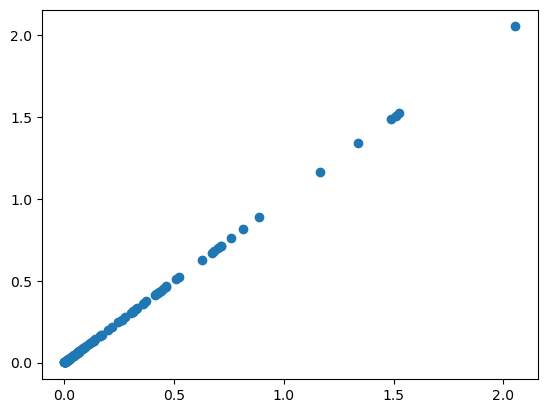

In [3]:
import gpytorch
from SOBER.FBGP._fitbo import FitboGP

gp_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
underlying_model = FitboGP(Xall, Yall, gp_kernel, device)

# visualise
y_pred = underlying_model.predict_mean(Xall)
plt.scatter(Yall, y_pred)

### 1.2 Sampling hypersamples without MCMC
We simply sample from hyperprior (log-normal distribution).<br>
Then, we compute the log marginal likelihood (LML) of GP model.<br>
The LML is used for computing the weights to estimate the hyperposterior distribution.<br>
Unlike MCMC, this process is not sequential, so we can parallelise this whole sampling process.<br>
For this demo, we do not parallelise but we can do it readily.

In [4]:
from SOBER.FBGP._hyperprior import RBFHyperPrior
from SOBER.FBGP._fully_Bayesian_gp import sampling_hypers

n_hypers = 1000 # number of hypersamples drawn from hyperprior

hyperprior = RBFHyperPrior()  # log normal distribution
hypersamples, lmls = sampling_hypers(
    underlying_model,   # FITBO model
    hyperprior,         # hyperprior
    n_hypers=n_hypers,  # number of hypersamples
    use_map=True,       # use MAP hyperparameters to update hyperprior
)

### 1.3 Quadrature distillation (QD)
We apply quadrature distillation for sparsifying the hypersamples.<br>
We use Bayesian quadrature to estimate the sparse set of weighted hyperparameters which approximate the hyperposterior distribution.<br>
We set hyper-GP over marginal likelihood to approximate the hyperparameter marginalisation with the small subset of hypersamples.<br>

In [5]:
from SOBER.FBGP._fully_Bayesian_gp import quadrature_distillation

n_nys = 100 # number of hypersamples for Nyström approximation
n_qd = 10   # number of distilled hyperparameters

w_qd, Theta_qd = quadrature_distillation(
    hypersamples, # hypersamples sampled from hyperprior
    lmls,         # log marginal likleihood
    gp_kernel,    # kernel for hyper-GP
    n_nys=n_nys,  # number of Nyström hypersamples
    n_qd=n_qd,    # number of resulted hypersamples
)

### 1.4 Fully Bayesian Gaussian Process (FBGP) model with sparse hyperparameters
We pass the distilled hypersamples (w_qd, Theta_qd) to FBGP model.<br>
As we can see, sparse FBGP model works quickly and finely.

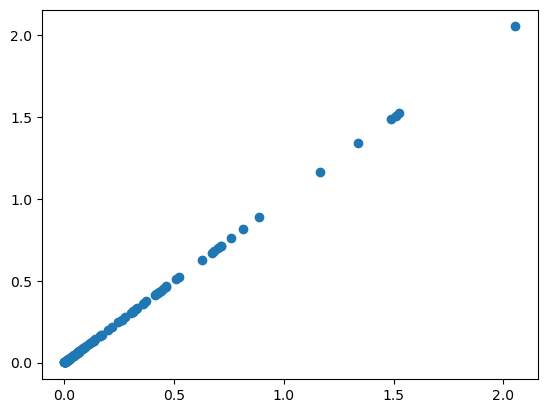

In [6]:
from SOBER.FBGP._fully_Bayesian_gp import FullyBayesianGP

fbgp = FullyBayesianGP(underlying_model, w_qd, Theta_qd)

# visualise
y_pred = fbgp.marginal_predictive_mean(Xall)
plt.scatter(Yall, y_pred)

### 1.5 Marginal acquisition functions
We can estimate marginal acquisition functions with fully Bayesian treatment.<br>
Quadrature distillation can accelerate acquisition function computation.<br>
We prepared 5 marginal acquisition functions:<br>
Select from ["EI", "UCB", "MES", "BQBC", "QBMGP"]<br>
- EI: marginal expected improvement
- UCB: marginal upper confidence bound
- MES: max-value entropy search
- BQBC: Bayesian query-by-committee
- QBMGP: Query by a mixture of Gaussian processes

We recommend MES, which performs well as far as we have tried.<br>
We can compute the information-theoretic function surprisingly fast.

In [7]:
from SOBER.FBGP._acquisition_function import FBGPAcquisitionFunction

AF = FBGPAcquisitionFunction(fbgp, label="MES")
start = time.monotonic()
AF(Xall)
end = time.monotonic()
wall_time = (end - start) / len(Xall) * 1e6
print(f"Acquisition time per sample [μs]: {wall_time:.5e}")

Acquisition time per sample [μs]: 5.89554e+02


### 1.6 Run SOBER
That's all! Running SOBER with an FBGP model is super easy, just passing the model to SOBER class.

In [8]:
def train_fbgp_model(
    Xall,
    Yall,
    n_hypers=1000,
    n_nys=100,
    n_qd=50,
):
    gp_kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    underlying_model = FitboGP(Xall, Yall, gp_kernel, device)
    hyperprior = RBFHyperPrior()
    hypersamples, lmls = sampling_hypers(
        underlying_model,
        hyperprior,
        n_hypers=n_hypers,
        use_map=True,
    )
    w_qd, Theta_qd = quadrature_distillation(
        hypersamples,
        lmls,
        gp_kernel,
        n_nys=n_nys,
        n_qd=n_qd,
    )
    fbgp = FullyBayesianGP(underlying_model, w_qd, Theta_qd)
    return fbgp

def visualise_results(results, y_true=None):
    idx_batch = torch.arange(n_iterations)

    fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8,4))
    ax[0].plot(idx_batch, results[:,1], 'bo-', label="observed maximum")
    if not y_true == None:
        ax[0].axhline(y=y_true, linestyle="--", color="k", label="ground truth")
    ax[0].legend()
    ax[0].set_xlabel("number of batches")
    ax[0].set_ylabel("y")

    ax[1].plot(idx_batch, results[:,0], 'bo-')
    ax[1].set_xlabel("number of batches")
    ax[1].set_ylabel("overhead [s]")
    plt.show()

--- generating the candidates from pi...
initial sampling...
update prior...
0-th recursive sampling...
--- Finished 3.802e+00 [s]
|| summary of sampling ||
 # of recombination samples: 1.840e+04
 # of Nyström samples: 5.000e+02
 # of nonzero weights: 1.840e+04
--- Start kernel recombination...
--- Finished all tasks 2.542e+01 [s]
200) Best value: 2.43464e+00
Acquisition time [s]: 3.40556e+01, per sample [ms]: 3.40556e+02
--- generating the candidates from pi...
initial sampling...
update prior...
0-th recursive sampling...
--- Finished 6.410e+00 [s]
|| summary of sampling ||
 # of recombination samples: 1.617e+04
 # of Nyström samples: 5.000e+02
 # of nonzero weights: 1.617e+04
--- Start kernel recombination...
--- Finished all tasks 2.692e+01 [s]
300) Best value: 2.43464e+00
Acquisition time [s]: 3.65281e+01, per sample [ms]: 3.65281e+02
--- generating the candidates from pi...
initial sampling...
update prior...
0-th recursive sampling...
--- Finished 6.944e+00 [s]
|| summary of sam

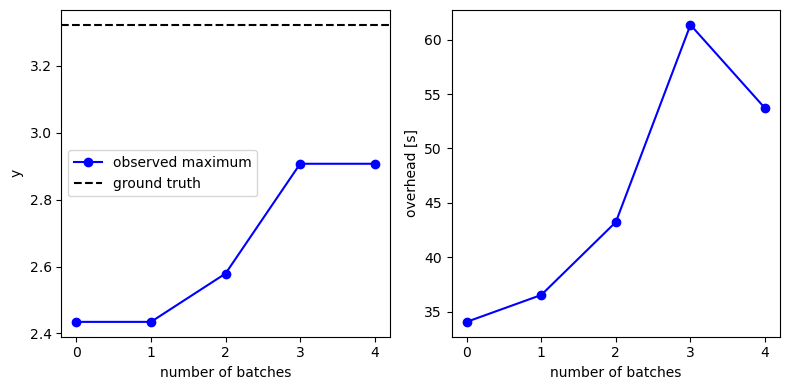

In [9]:
from SOBER._sober import Sober

n_rec = 20000       # number of candidates to select batch queries
n_nys = 500         # number of samples for Nyström approximation for batch queries
batch_size = 100    # batch size
n_hypers = 1000     # number of hypersamples for QD
n_nys_qd = 100      # number of hypersamples for Nyström approximation for QD
n_qd = 10           # number of QD samples
n_iterations = 5    # number of iterations
af_type = "MES"     # The type of acquisition function

results = []
sober = Sober(prior, fbgp)  # load FBGP model and prior
for n_iter in range(n_iterations):
    start = time.monotonic()
    fbgp = train_fbgp_model(
        Xall,
        Yall,
        n_hypers=n_hypers,
        n_nys=n_nys_qd,
        n_qd=n_qd,
    )
    sober.update_model(fbgp)     # pass the updated FBGP model to sober
    AF = FBGPAcquisitionFunction(fbgp, label=af_type) # Set marginal acquisition function
    X_batch = sober.next_batch(
        n_rec,
        n_nys,
        batch_size,
        calc_obj=AF,
        verbose=True,
    )
    end = time.monotonic()
    interval = end - start
    
    Y_batch = TestFunction(X_batch)
    Xall = torch.cat((Xall, X_batch), dim=0)
    Yall = torch.cat((Yall, Y_batch), dim=0)

    print(f"{len(Xall)}) Best value: {Yall.max().item():.5e}")
    print(f"Acquisition time [s]: {interval:.5e}, per sample [ms]: {interval/batch_size*1e3:.5e}")
    results.append([interval, Yall.max().item()])

results = torch.tensor(results)
visualise_results(results, y_true=3.32237)